In [1]:
suppressPackageStartupMessages({
    library(VariantAnnotation)
    library(rtracklayer)
    library(tidyverse)
    library(ggbeeswarm)
    library(purrr)
    library(parallel)
    library(slimr)
    library(stringr)
    library(forcats)
})

In [2]:
assembly_gaps_path <- "../data/RData/assembly_gaps.rds"

if (!file.exists(assembly_gaps_path)) {
    assembly_gaps <- get_gaps()
    saveRDS(assembly_gaps, assembly_gaps_path)
} else {
    assembly_gaps <- readRDS(assembly_gaps_path)
}

In [3]:
find_deserts <- function(vcf_path, region) {
    vcf <- read_vcf(vcf_path)
    r <- ifelse(str_detect(region, "neutral"), "tf_binding_site", region)

    real_markers <- read_coordinates(paste0("../data/slim_coords/", r, "_all_sites.bed"))
    slim_markers <- mut_info(vcf, mut_type = 1)

    slim_markers <- fill_lost(slim_markers, real_markers) %>% transpose_coordinates(real_markers) 

    slim_regions <- read_coordinates(paste0("../data/slim_coords/", r, "_regions.bed"))
    regions <- transpose_coordinates(slim_regions, slim_regions)
    
    gap_markers <- slim_markers[! slim_markers %over% regions, ]
    
    deserts <- ancestry_deserts(gap_markers)

    if (is.null(deserts)) return(NULL)
    desert_hits <- queryHits(findOverlaps(deserts, assembly_gaps))
    nogap_deserts <- if (length(desert_hits)) deserts[-desert_hits] else deserts
        
    nogap_deserts
}

In [4]:
regions <- c("merged", "exon", "promoter", "protein_coding", "tf_binding_site", "utr3", "neutral")

In [5]:
region_sizes <- sapply(regions, function(reg) {
    r <- ifelse(str_detect(reg, "neutral"), "tf_binding_site", reg)
    gr <- import.bed(paste0("../data/bed/regions/", r, "_regions.bed"))
    sum(width(gr))
})
region_sizes["neutral"] <- 0

### Single pulse of admixture

In [6]:
desert_sizes <- lapply(1:5, function(rep_i) {

map(regions, function(region) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_", region, "_h_0.5_rep_", rep_i, "_gen_2200.vcf.gz"),
        region = region
    )

    if (is.null(deserts)) return(NULL)
    else tibble(region = region, size=width(deserts), rep=rep_i)
}) %>% bind_rows

}) %>% bind_rows %>%
    mutate(region=factor(region, levels=names(region_sizes)[order(region_sizes, decreasing=TRUE)]))

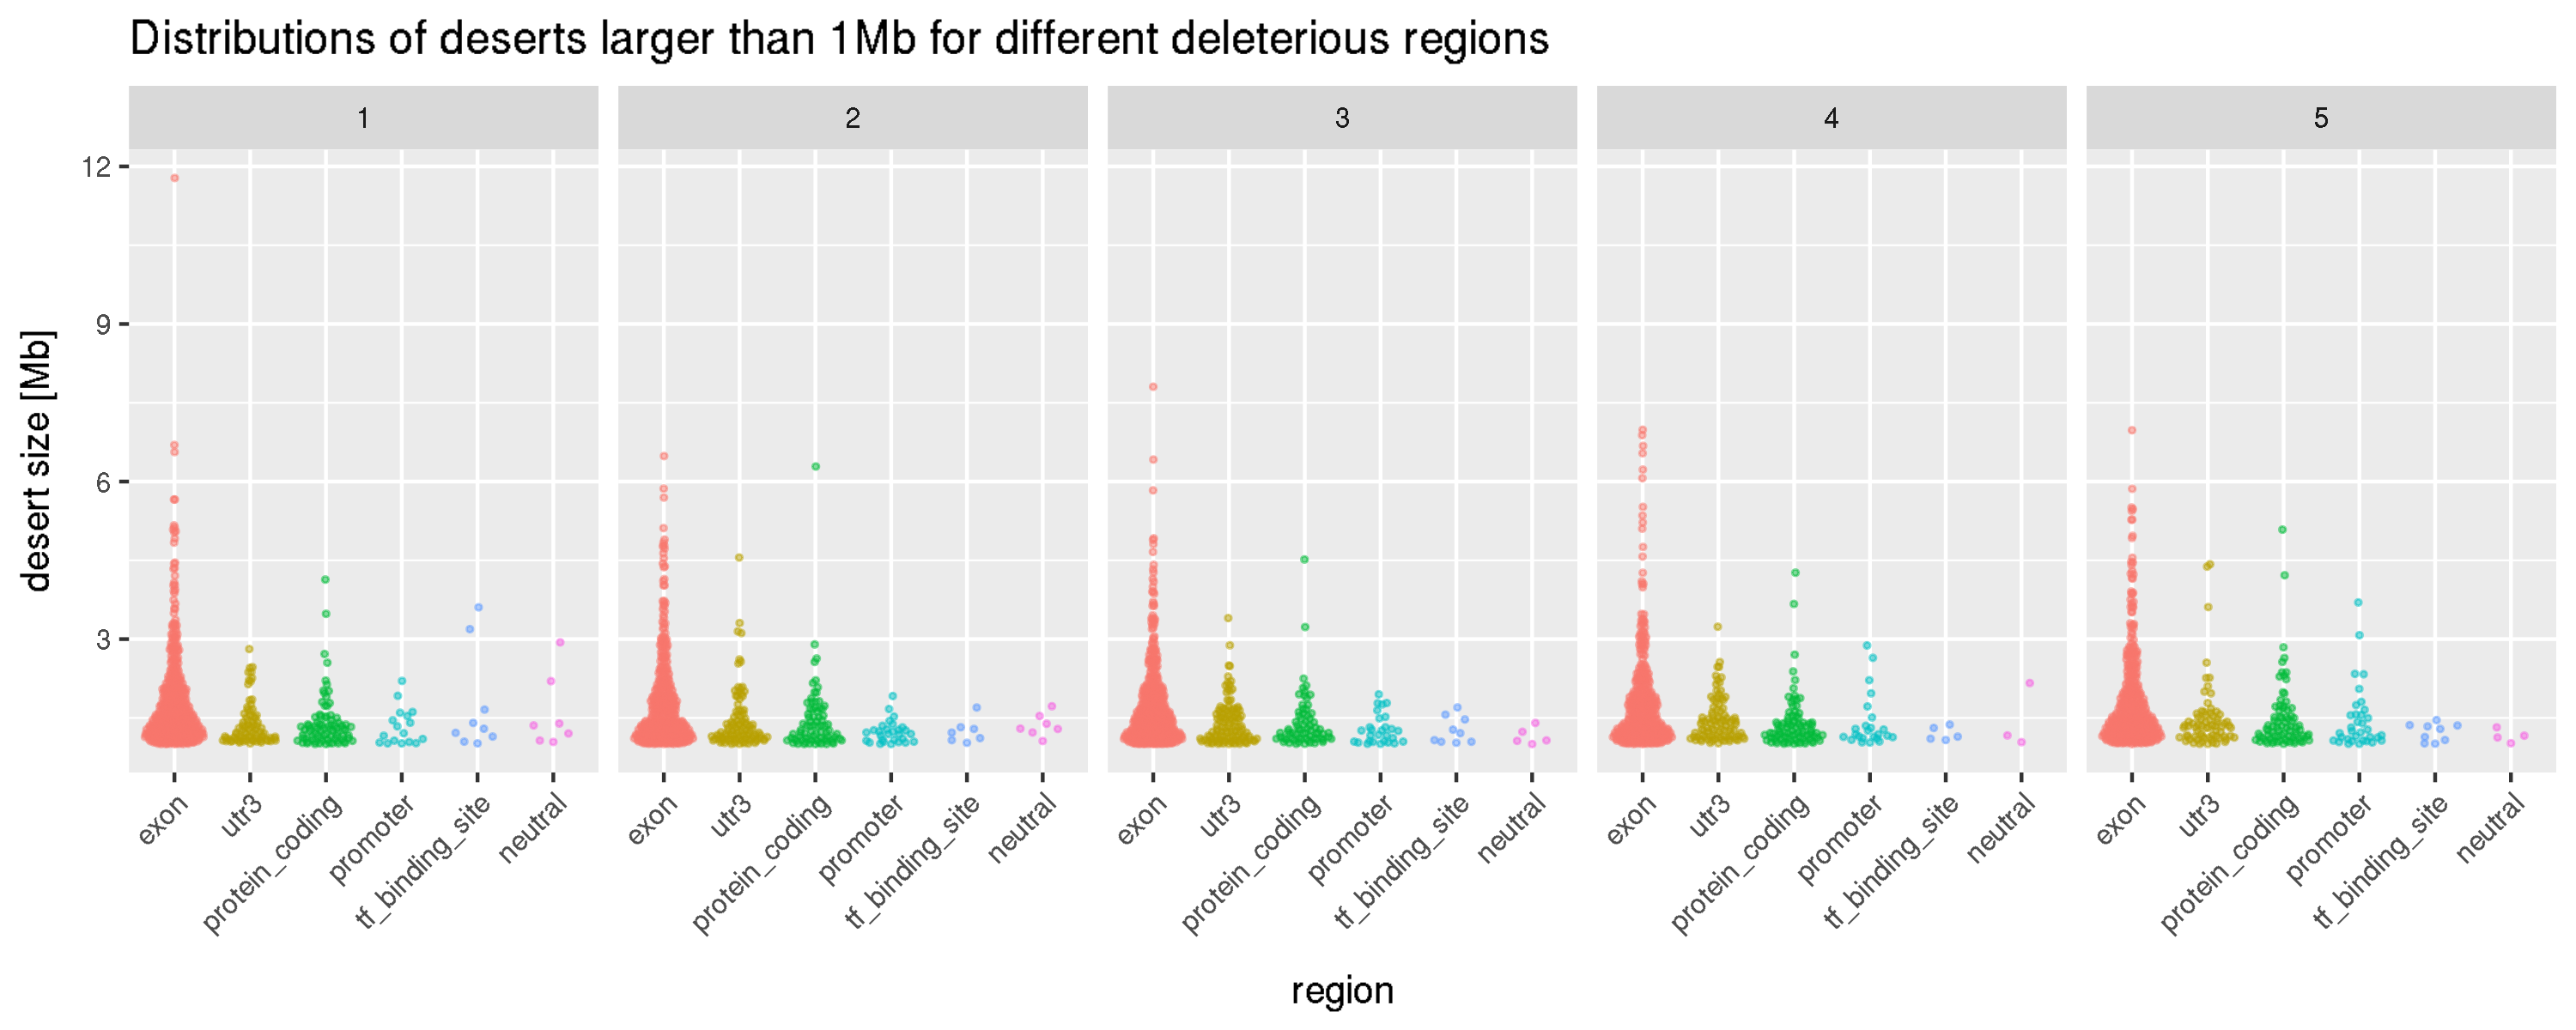

In [7]:
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=300)

group_by(desert_sizes, region, rep) %>% filter(size > 1e6, region != "merged") %>%
ggplot(aes(region, size / 1e6, color=region)) + geom_quasirandom(alpha=1/2, size=0.5) +
ggtitle("Distributions of deserts larger than 1Mb for different deleterious regions") +
ylab("desert size [Mb]") +
facet_grid(. ~ rep) +
theme(legend.position="botom", axis.text.x=element_text(hjust=1, angle=45))

### Desert size summary stats for all regions

In [8]:
group_by(desert_sizes, region) %>% summarise(mean(size),
                                             median(size),
                                             min(size),
                                             max(size))

region,mean(size),median(size),min(size),max(size)
merged,4305993.0,1554652,114,78508751
exon,478413.9,233980,2,11780012
utr3,215868.9,115420,2,4553376
protein_coding,205491.3,105527,2,6286775
promoter,152413.6,83536,2,3698296
tf_binding_site,123033.2,68249,2,3605356
neutral,106133.3,55828,2,2938404


# Neandertal deserts from 20 independent burnins

In [517]:
trajectories <- suppressMessages(bind_rows(
    map_dfr(list.files("../data/simulations/", "deserts_indep_neutral_rep_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(selection = "neutral", rep = .x)),
    map_dfr(list.files("../data/simulations/", "deserts_indep_neutral2p_rep_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(selection = "neutral2p", rep = .x)),
    map_dfr(list.files("../data/simulations/", "deserts_indep_exon_rep_.*.txt", full.names = TRUE), ~ read_tsv(.x) %>% mutate(selection = "exon", rep = .x))
))

`geom_smooth()` using method = 'loess'


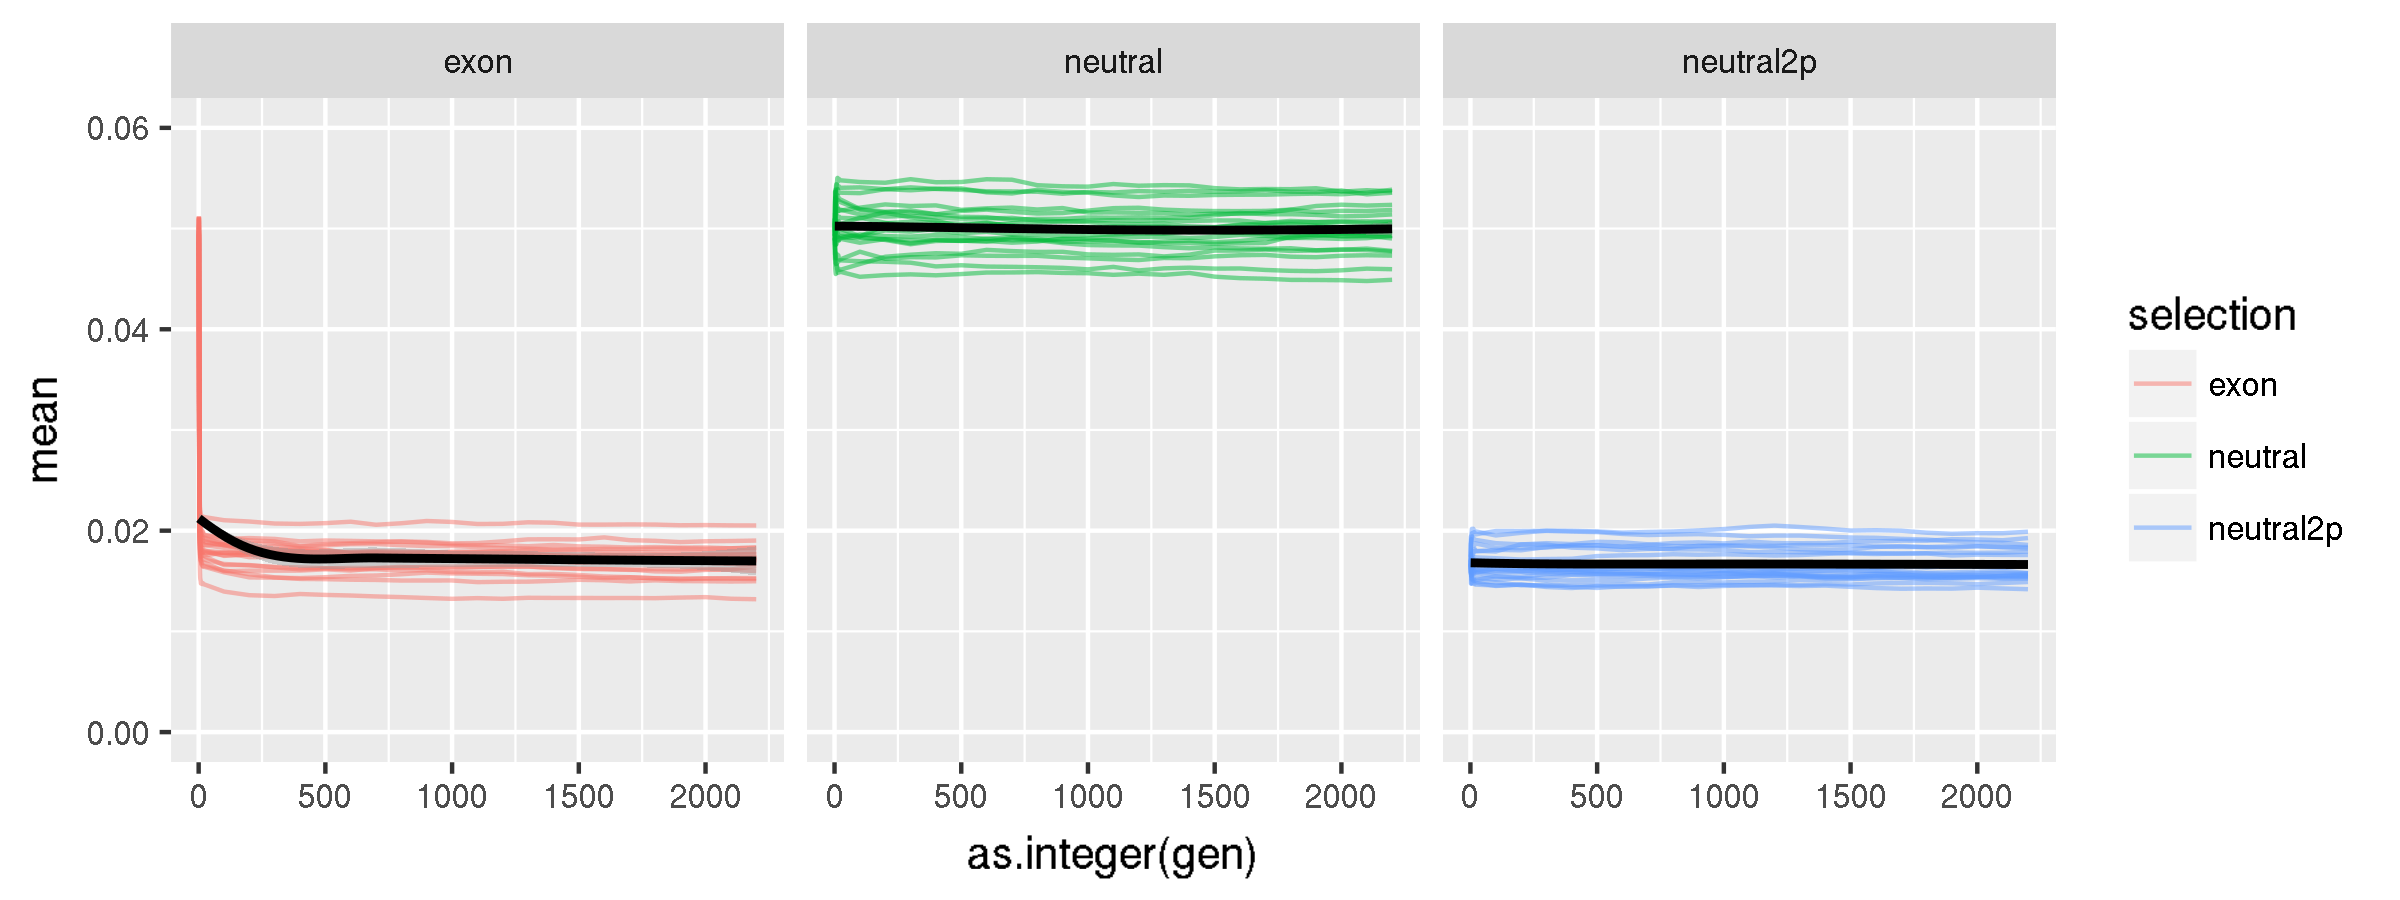

In [518]:
options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(trajectories, aes(as.integer(gen), mean, color = selection, group = rep)) + geom_line(alpha = 1/2) + geom_smooth(aes(group = 1), color = "black") + facet_grid(. ~ selection) + ylim(0, 0.06)

In [519]:
# AF changes over time
gens <- c(1, 5, 10, 20, 50, 100, seq(200, 2200, 200))

In [210]:
time_deserts_exon <- lapply(1:20, function(rep_i) {
    
mclapply(mc.cores=length(gens), gens, function(gen) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_indep_exon_rep_", rep_i, "_gen_", gen, ".vcf.gz"),
        region = "exon"
    )

    if (is.null(deserts)) return(NULL)
    else tibble(gen=gen, size=width(deserts), rep=rep_i)
}) %>% bind_rows
    
}) %>% bind_rows

time_deserts_neutral <- lapply(1:20, function(rep_i) {
    
mclapply(mc.cores=length(gens), gens, function(gen) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_indep_neutral_rep_", rep_i, "_gen_", gen, ".vcf.gz"),
        region = "exon"
    )

    if (is.null(deserts)) return(NULL)
    else tibble(gen=gen, size=width(deserts), rep=rep_i)
}) %>% bind_rows
    
}) %>% bind_rows


time_deserts_neutral2p <- lapply(1:20, function(rep_i) {
    
mclapply(mc.cores=length(gens), gens, function(gen) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_indep_neutral2p_rep_", rep_i, "_gen_", gen, ".vcf.gz"),
        region = "exon"
    )

    if (is.null(deserts)) return(NULL)
    else tibble(gen=gen, size=width(deserts), rep=rep_i)
}) %>% bind_rows
    
}) %>% bind_rows

In [521]:
time_deserts <- bind_rows(
    mutate(time_deserts_exon, selection = "exon"),
    mutate(time_deserts_neutral, selection = "neutral"),
    mutate(time_deserts_neutral2p, selection = "neutral2p")
)

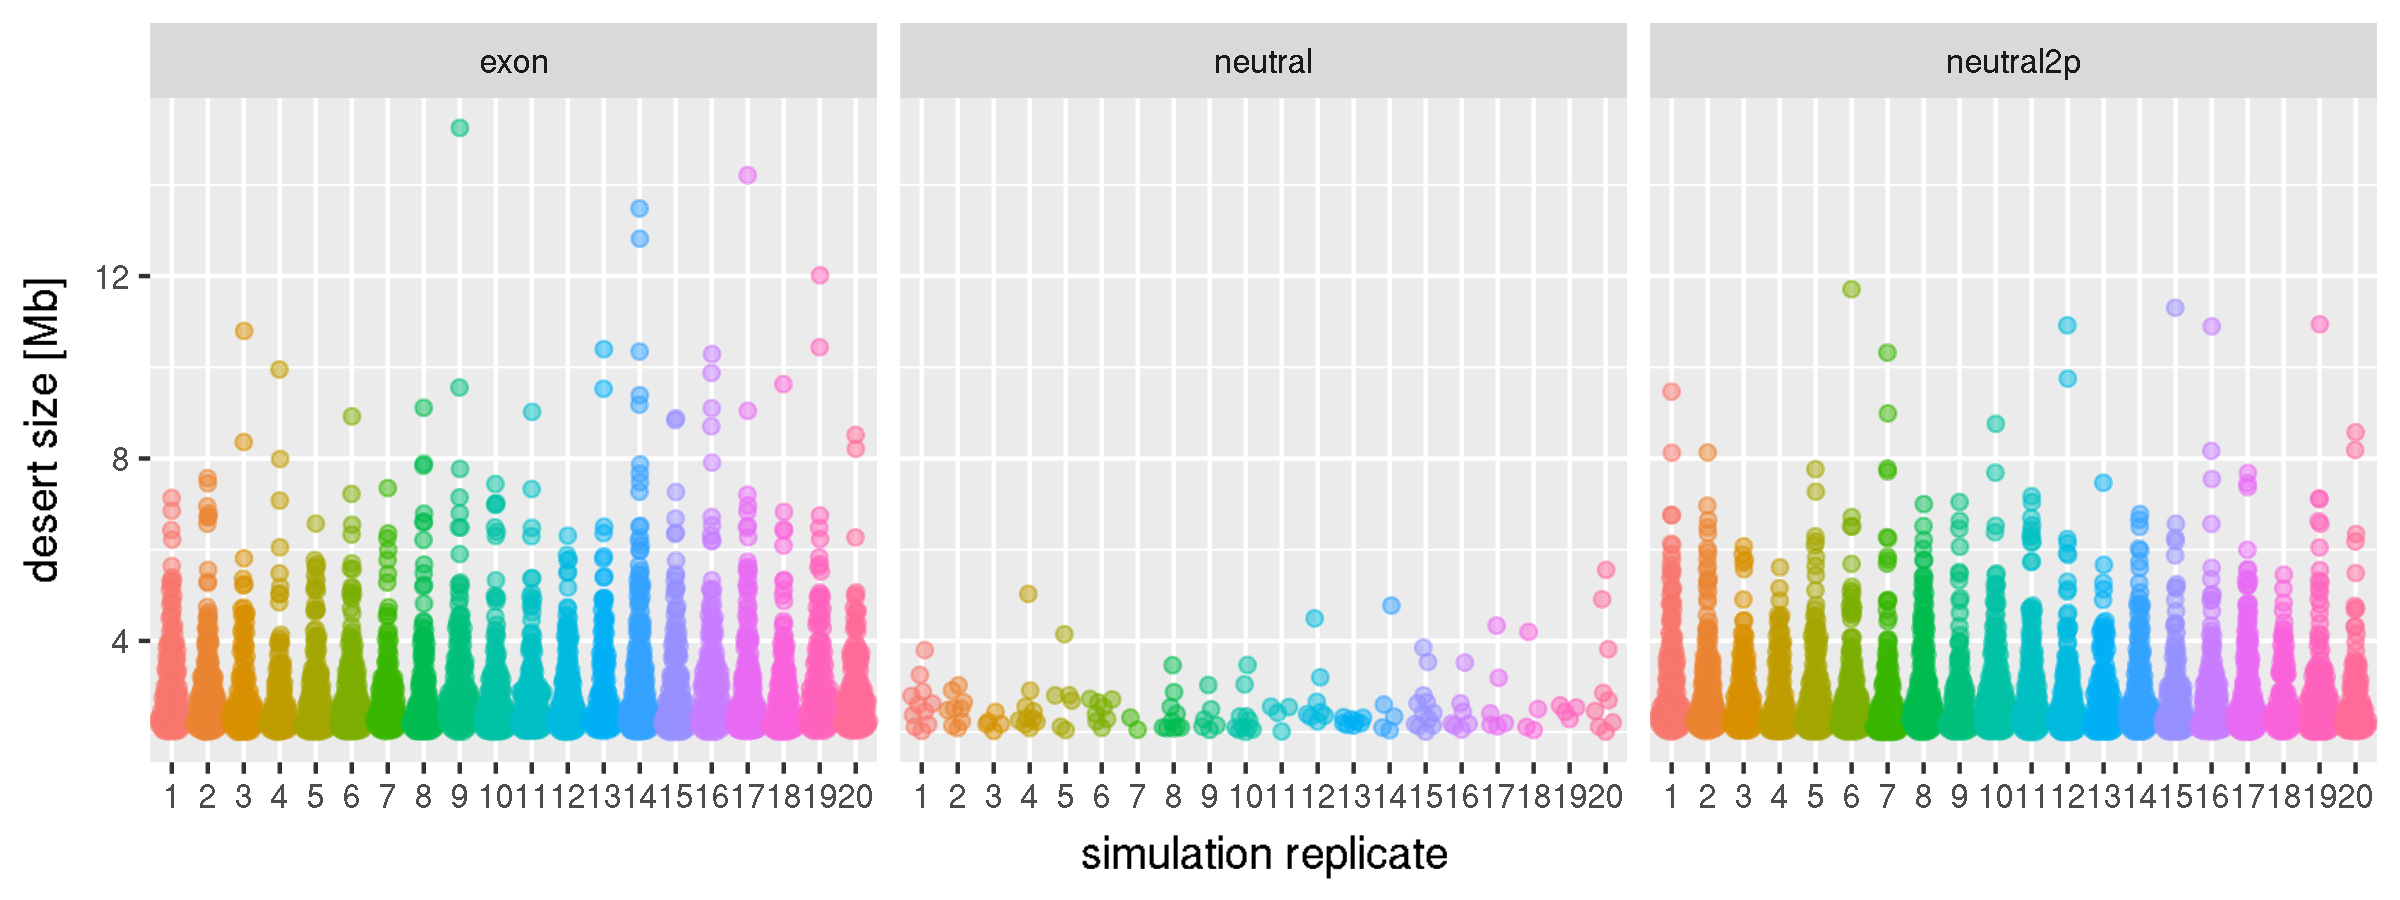

In [522]:
options(repr.plot.width=8, repr.plot.height=3, repr.plot.res=300)

time_deserts %>% filter(gen == 2200, size > 2e6) %>% mutate(rep = factor(rep)) %>%
ggplot(aes(rep, size / 1e6, color = factor(rep))) +
    geom_quasirandom(alpha=1/2) +
    xlab("simulation replicate") + ylab("desert size [Mb]") +
    facet_grid(. ~ selection) +
    #theme_classic() +
    theme(legend.position = "none")

### Proportion of the genome covered by deserts over time

`geom_smooth()` using method = 'loess'


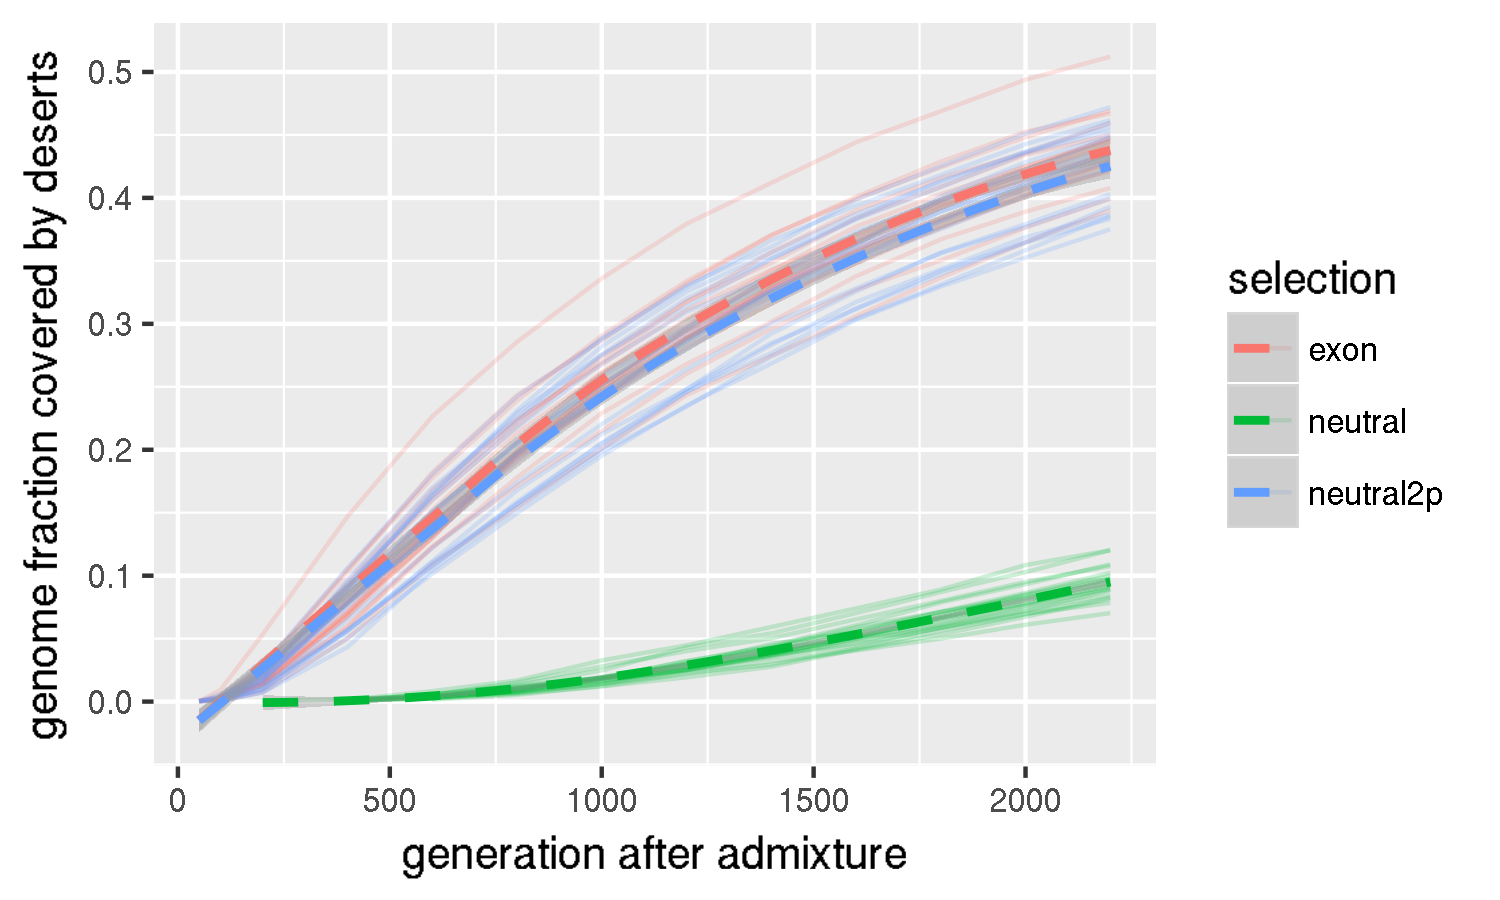

In [523]:
options(repr.plot.width=5, repr.plot.height=3, repr.plot.res=300)

time_deserts %>% filter(size > 500000) %>%
group_by(gen, rep, selection) %>% summarise(size = sum(size)) %>% ungroup %>%
mutate(rep = paste0(selection, rep)) %>%
ggplot(aes(gen, size / (3e9 - sum(width(assembly_gaps))), color = selection, group = rep)) + geom_line(alpha = 1/5) +
    xlab("generation after admixture") + ylab("genome fraction covered by deserts") +
    geom_smooth(aes(group = selection), linetype = 2)

In [398]:
saveRDS(time_deserts, "../paper/rds/desert_sizes.rds")

In [394]:
time_deserts %>% head

gen,size,rep,selection
50,526742,1,exon
50,25774,1,exon
100,371118,1,exon
100,246954,1,exon
100,94505,1,exon
100,501800,1,exon


In [377]:
exon <- find_deserts(
    vcf_path = paste0("../data/simulations/deserts_indep_exon_rep_", 1, "_gen_", 2200, ".vcf.gz"),
    region = "exon"
)

neutral <- find_deserts(
    vcf_path = paste0("../data/simulations/deserts_indep_neutral_rep_", 1, "_gen_", 2200, ".vcf.gz"),
    region = "exon"
)

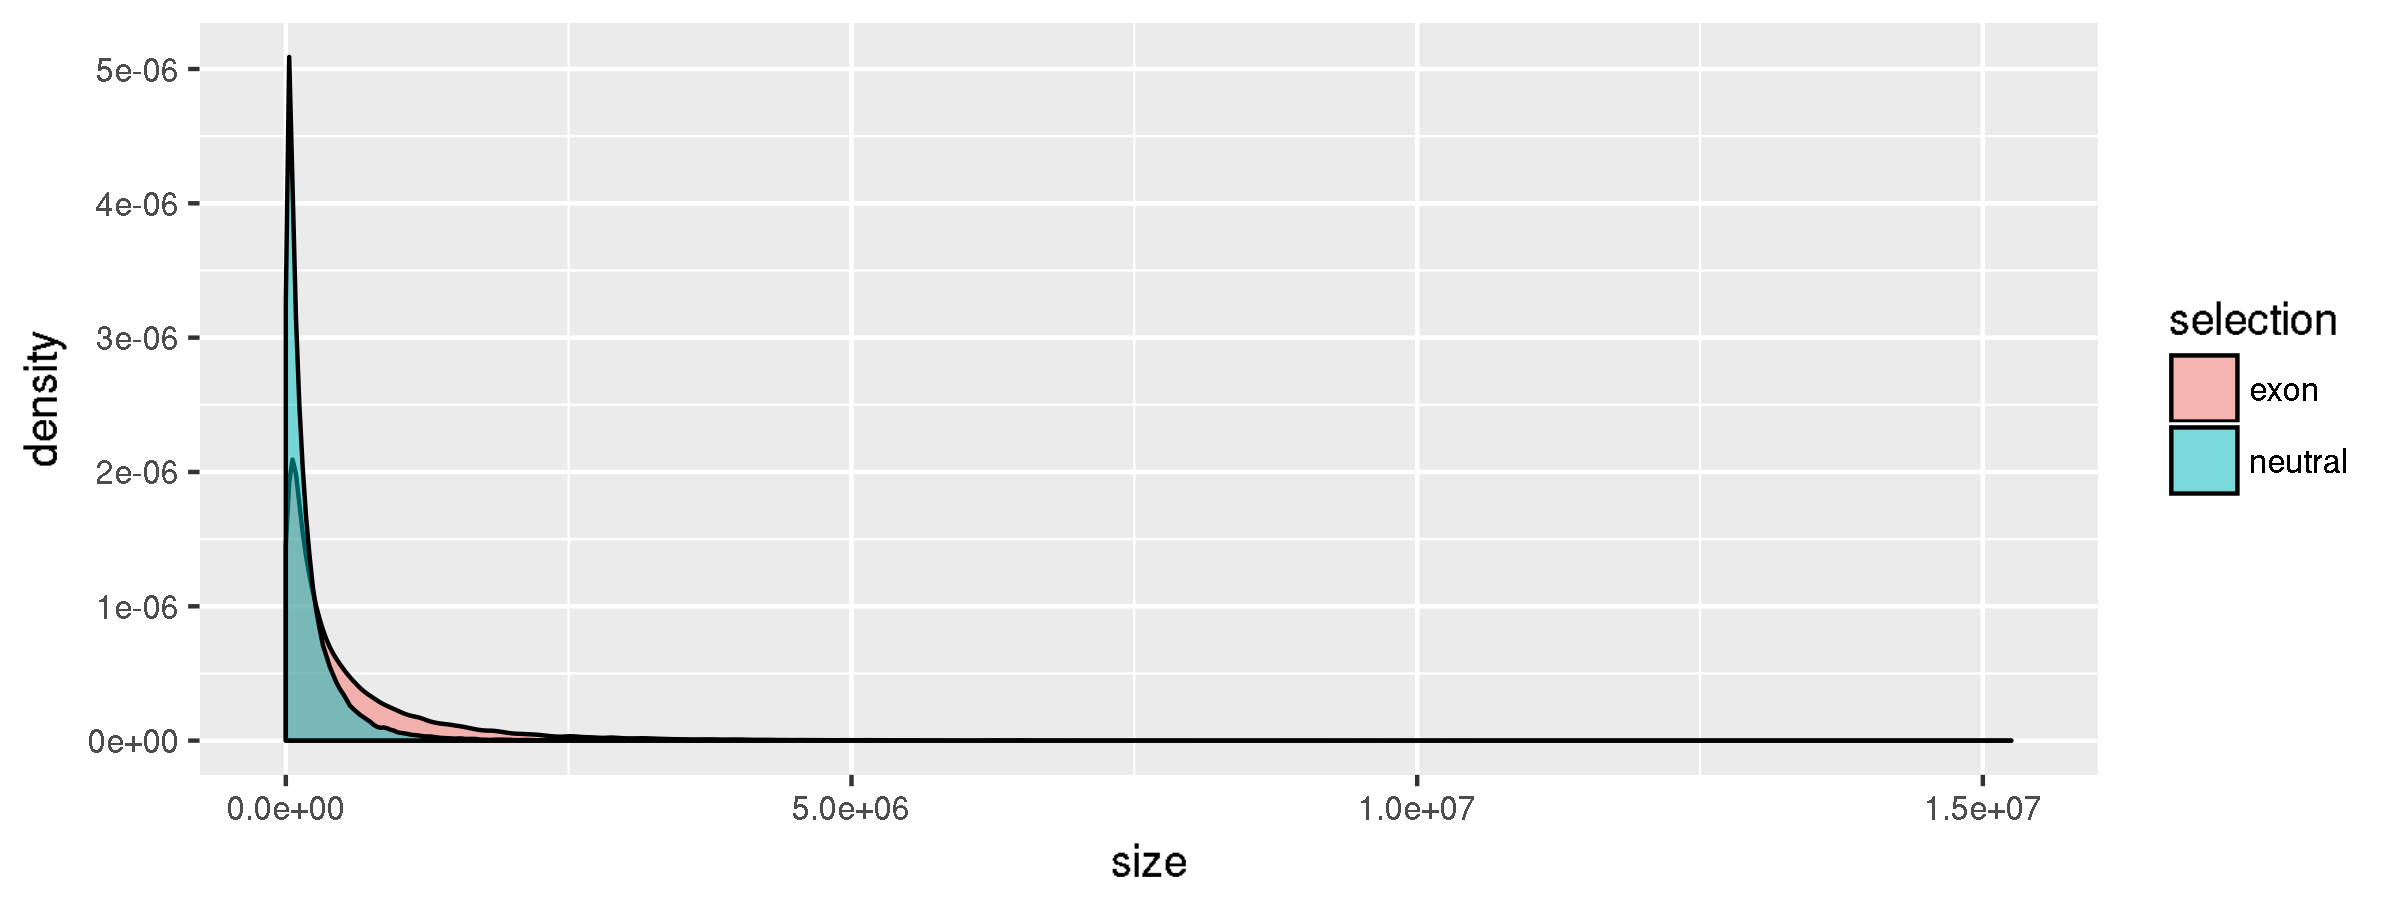

In [397]:
filter(time_deserts, gen == 2200) %>%
ggplot(aes(size, fill = selection)) + geom_density(alpha = 1/2)

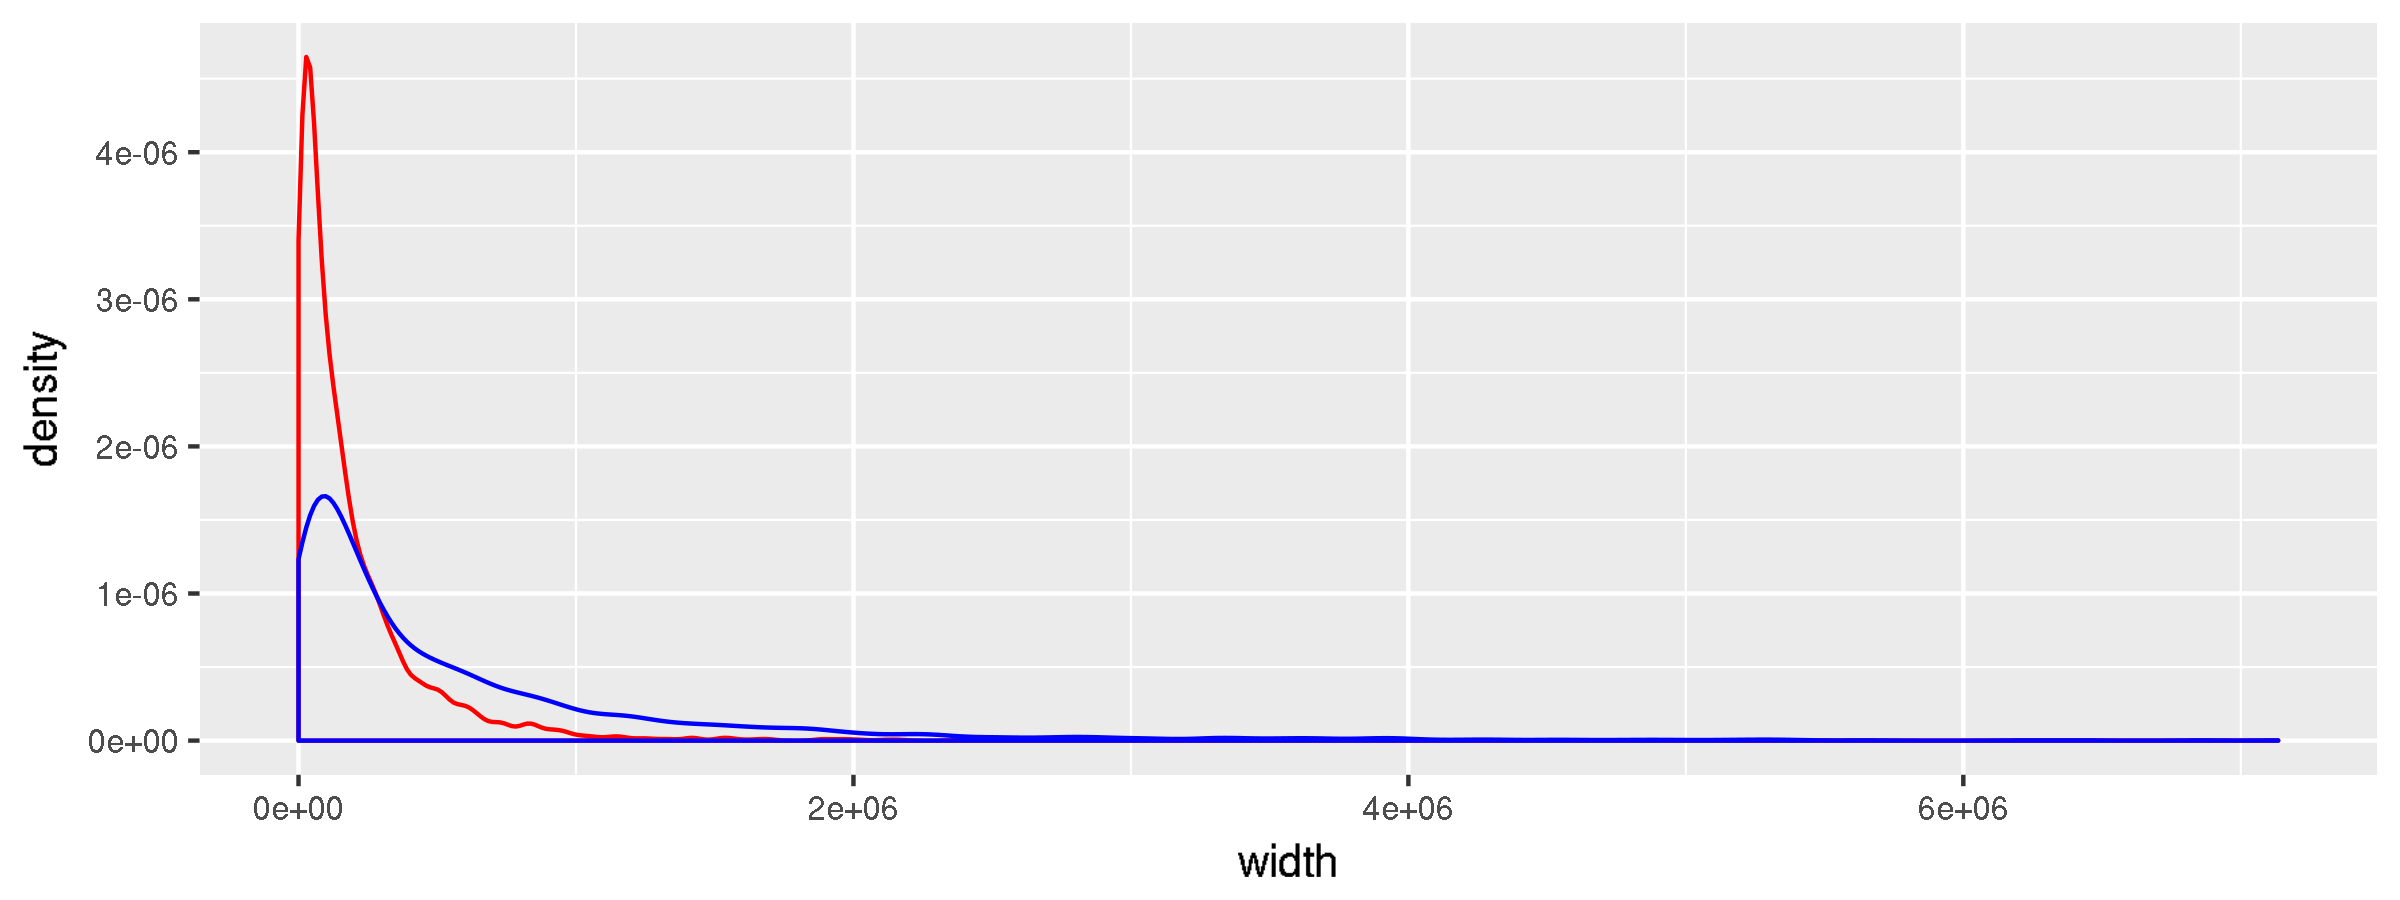

In [393]:
ggplot() +
    geom_density(data=as.data.frame(neutral), aes(width), color = "red", alpha = 1/2) +
    geom_density(data=as.data.frame(exon), aes(width), color = "blue", alpha = 1/2)

## Overlap of deserts

Let's take the 10 biggest deserts from each exon replicate and look at their overlap.

In [15]:
library(BSgenome.Hsapiens.UCSC.hg19)
library(ggbio)

Loading required package: BSgenome
Need specific help about ggbio? try mailing 
 the maintainer or visit http://tengfei.github.com/ggbio/

Attaching package: 'ggbio'

The following objects are masked from 'package:ggplot2':

    geom_bar, geom_rect, geom_segment, ggsave, stat_bin, stat_identity,
    xlim



In [17]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
seqlevels(hg19, pruning.mode="coarse") <- paste0("chr", 1:22)

In [20]:
large_deserts_nea <- lapply(1:20, function(rep_i) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_source_p2_exon_rep_", rep_i, "_run_1_gen_2200.vcf.gz"),
        region = "exon"
    )

    largest <- deserts[width(deserts) > 5e6]
    largest$rep <- rep_i
    
    seqinfo(largest) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
    seqlevels(largest, pruning.mode="coarse") <- paste0("chr", 1:22)

    largest
})

In [22]:
large_deserts_den <- lapply(1:20, function(rep_i) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_source_p4_exon_rep_", rep_i, "_run_1_gen_2200.vcf.gz"),
        region = "exon"
    )

    largest <- deserts[width(deserts) > 5e6]
    largest$rep <- rep_i
    
    seqinfo(largest) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
    seqlevels(largest, pruning.mode="coarse") <- paste0("chr", 1:22)

    largest
})

In [17]:
hg19 <- GRanges(seqinfo(BSgenome.Hsapiens.UCSC.hg19))
seqlevels(hg19, pruning.mode="coarse") <- paste0("chr", 1:22)

In [99]:
plot_desert <- function(gr) {
    circle(gr, geom = "rect", aes(fill = factor(rep), color = factor(rep)))
}

### This is a very weird plot that tries to show an overlap between > 5 Mb deserts of Neandertal and Denisovan ancestry (independent).


Pairs of block of the same color show Neandertal and Denisovan deserts ran from the same burnin:

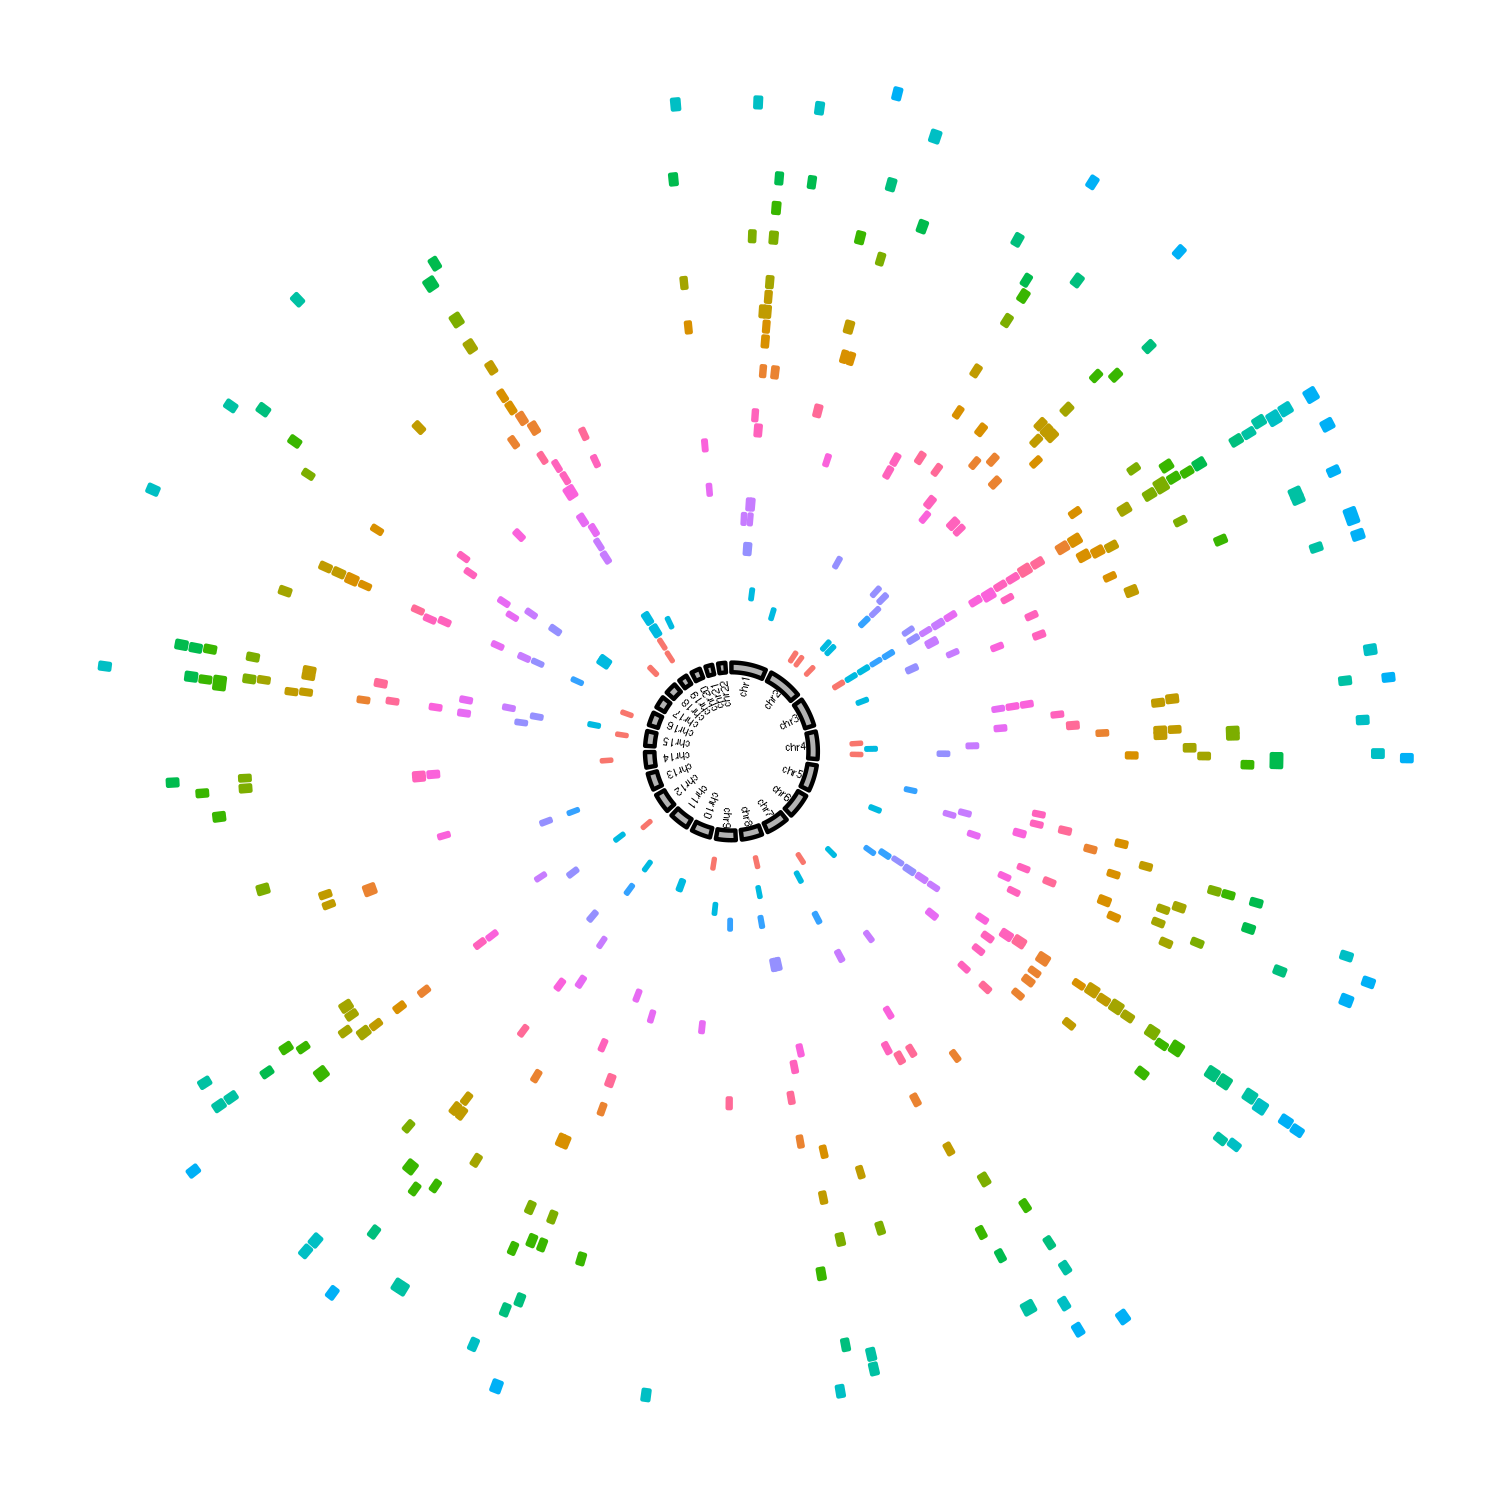

In [308]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

ggbio() + circle(hg19, geom = "rect", fill = "gray70") +
    circle(hg19, geom = "text", aes(label = seqnames, angle = 90), hjust = 2, size = 0.8) +
    plot_desert(large_deserts_nea[[1]]) + plot_desert(large_deserts_den[[1]]) + 
    plot_desert(large_deserts_nea[[2]]) + plot_desert(large_deserts_den[[2]]) + 
    plot_desert(large_deserts_nea[[3]]) + plot_desert(large_deserts_den[[3]]) + 
    plot_desert(large_deserts_nea[[4]]) + plot_desert(large_deserts_den[[4]]) + 
    plot_desert(large_deserts_nea[[5]]) + plot_desert(large_deserts_den[[5]]) + 
    plot_desert(large_deserts_nea[[6]]) + plot_desert(large_deserts_den[[6]]) + 
    plot_desert(large_deserts_nea[[7]]) + plot_desert(large_deserts_den[[7]]) + 
    plot_desert(large_deserts_nea[[8]]) + plot_desert(large_deserts_den[[8]]) + 
    plot_desert(large_deserts_nea[[9]]) + plot_desert(large_deserts_den[[9]]) + 
    plot_desert(large_deserts_nea[[10]]) + plot_desert(large_deserts_den[[10]]) + 
    plot_desert(large_deserts_nea[[11]]) + plot_desert(large_deserts_den[[11]]) + 
    plot_desert(large_deserts_nea[[12]]) + plot_desert(large_deserts_den[[12]]) + 
    plot_desert(large_deserts_nea[[13]]) + plot_desert(large_deserts_den[[13]]) + 
    plot_desert(large_deserts_nea[[14]]) + plot_desert(large_deserts_den[[14]]) + 
    plot_desert(large_deserts_nea[[15]]) + plot_desert(large_deserts_den[[15]]) + 
    plot_desert(large_deserts_nea[[16]]) + plot_desert(large_deserts_den[[16]]) + 
    plot_desert(large_deserts_nea[[17]]) + plot_desert(large_deserts_den[[17]]) + 
    plot_desert(large_deserts_nea[[18]]) + plot_desert(large_deserts_den[[18]]) + 
    plot_desert(large_deserts_nea[[19]]) + plot_desert(large_deserts_den[[19]]) + 
    plot_desert(large_deserts_nea[[20]]) + plot_desert(large_deserts_den[[20]]) +
    theme(legend.position = "none")

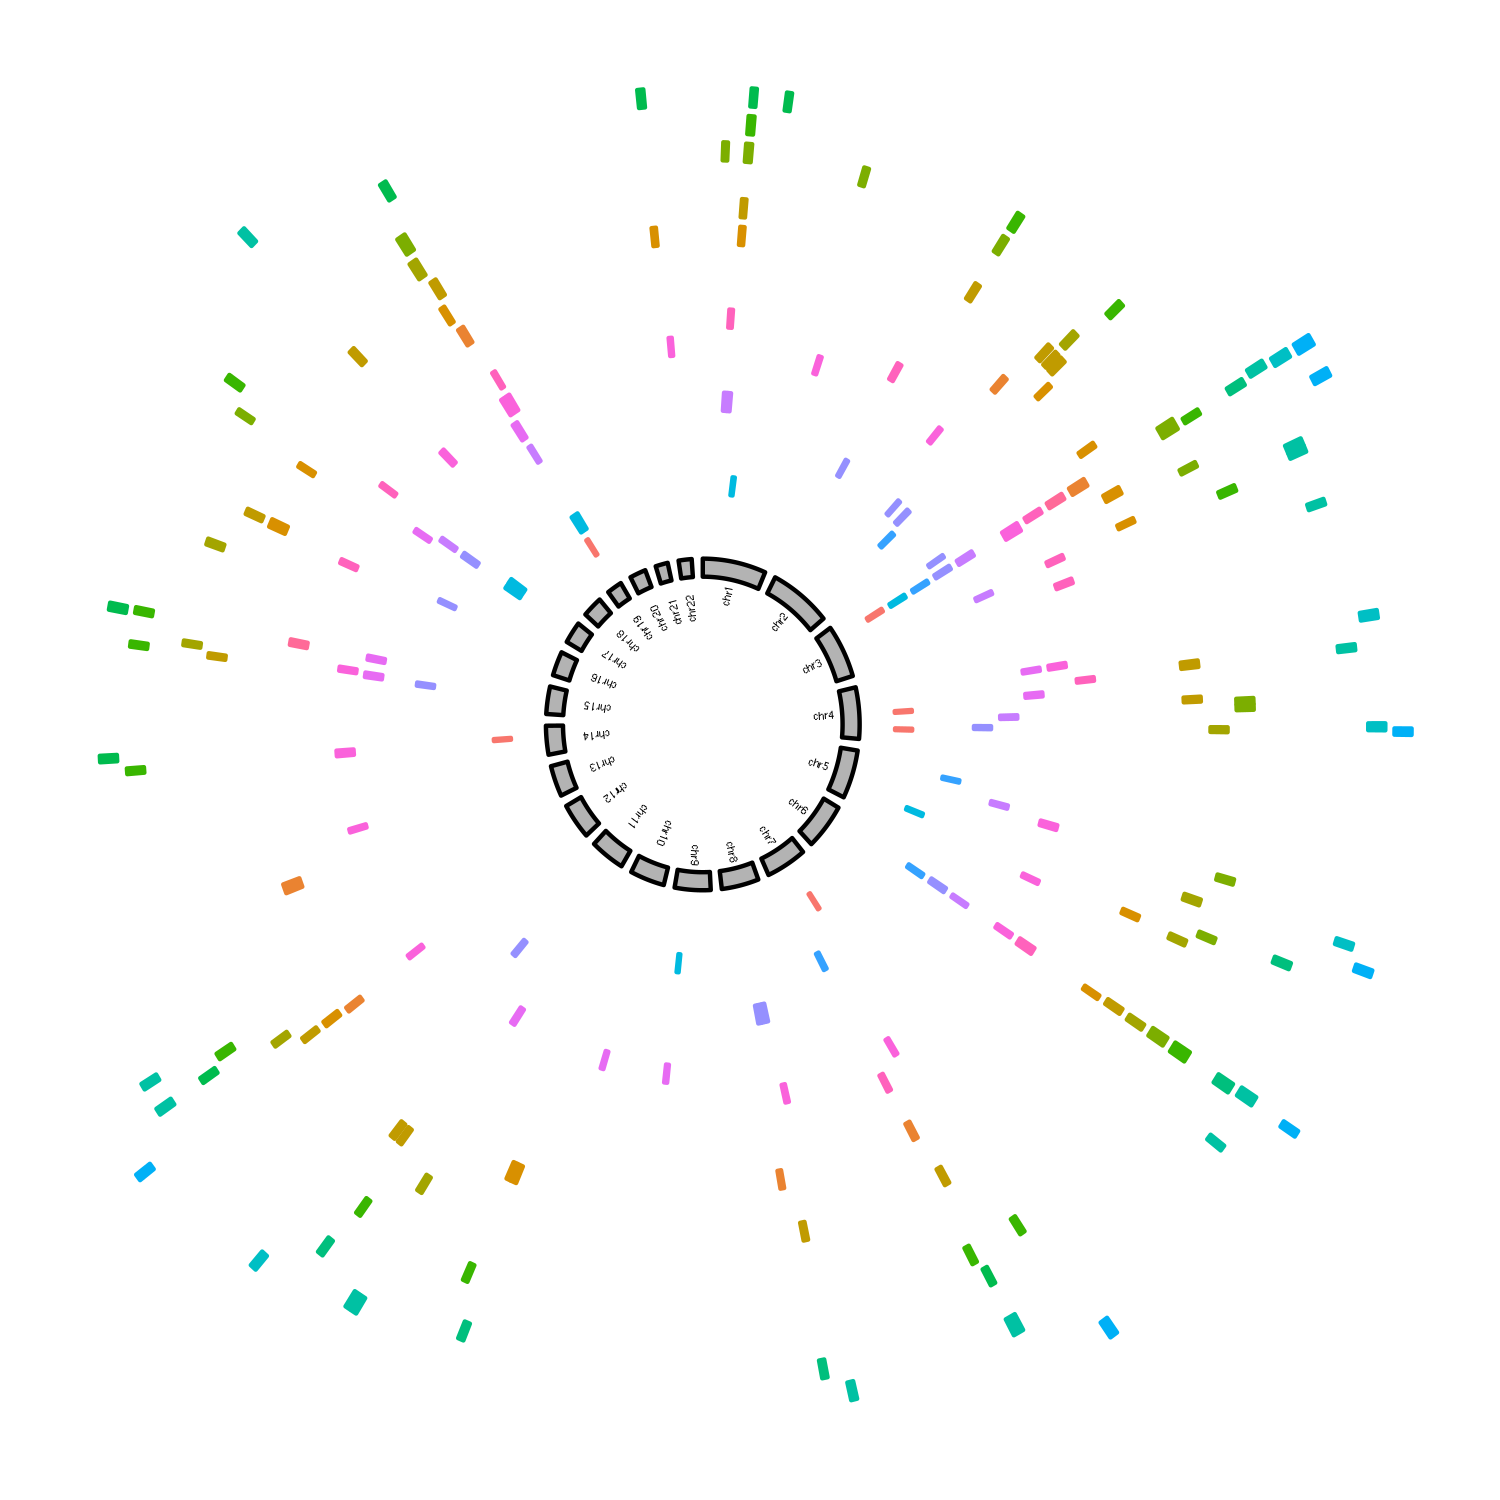

In [316]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

ggbio() + circle(hg19, geom = "rect", fill = "gray70") +
    circle(hg19, geom = "text", aes(label = seqnames, angle = 90), hjust = 3, size = 1) +
    plot_desert(large_deserts_den[[1]]) +
    plot_desert(large_deserts_den[[2]]) +
    plot_desert(large_deserts_den[[3]]) +
    plot_desert(large_deserts_den[[4]]) +
    plot_desert(large_deserts_den[[5]]) +
    plot_desert(large_deserts_den[[6]]) +
    plot_desert(large_deserts_den[[7]]) +
    plot_desert(large_deserts_den[[8]]) +
    plot_desert(large_deserts_den[[9]]) +
    plot_desert(large_deserts_den[[10]]) +
    plot_desert(large_deserts_den[[11]]) +
    plot_desert(large_deserts_den[[12]]) +
    plot_desert(large_deserts_den[[13]]) +
    plot_desert(large_deserts_den[[14]]) +
    plot_desert(large_deserts_den[[15]]) +
    plot_desert(large_deserts_den[[16]]) +
    plot_desert(large_deserts_den[[17]]) +
    plot_desert(large_deserts_den[[18]]) +
    plot_desert(large_deserts_den[[19]]) +
    plot_desert(large_deserts_den[[20]]) +
    theme(legend.position = "none")

In [526]:
large_deserts_neutral <- lapply(1:20, function(rep_i) {
    deserts <- find_deserts(
        vcf_path = paste0("../data/simulations/deserts_indep_neutral2p_rep_", rep_i, "_gen_2200.vcf.gz"),
        region = "exon"
    )
    
    if (any(width(deserts) > 5e6)) {
        largest <- deserts[width(deserts) > 5e6]
        largest$rep <- rep_i
        

    seqinfo(largest) <- seqinfo(BSgenome.Hsapiens.UCSC.hg19)
    seqlevels(largest, pruning.mode="coarse") <- paste0("chr", 1:22)
        
    } else {
        largest <- NULL
    }
    
    largest
}) %>% compact

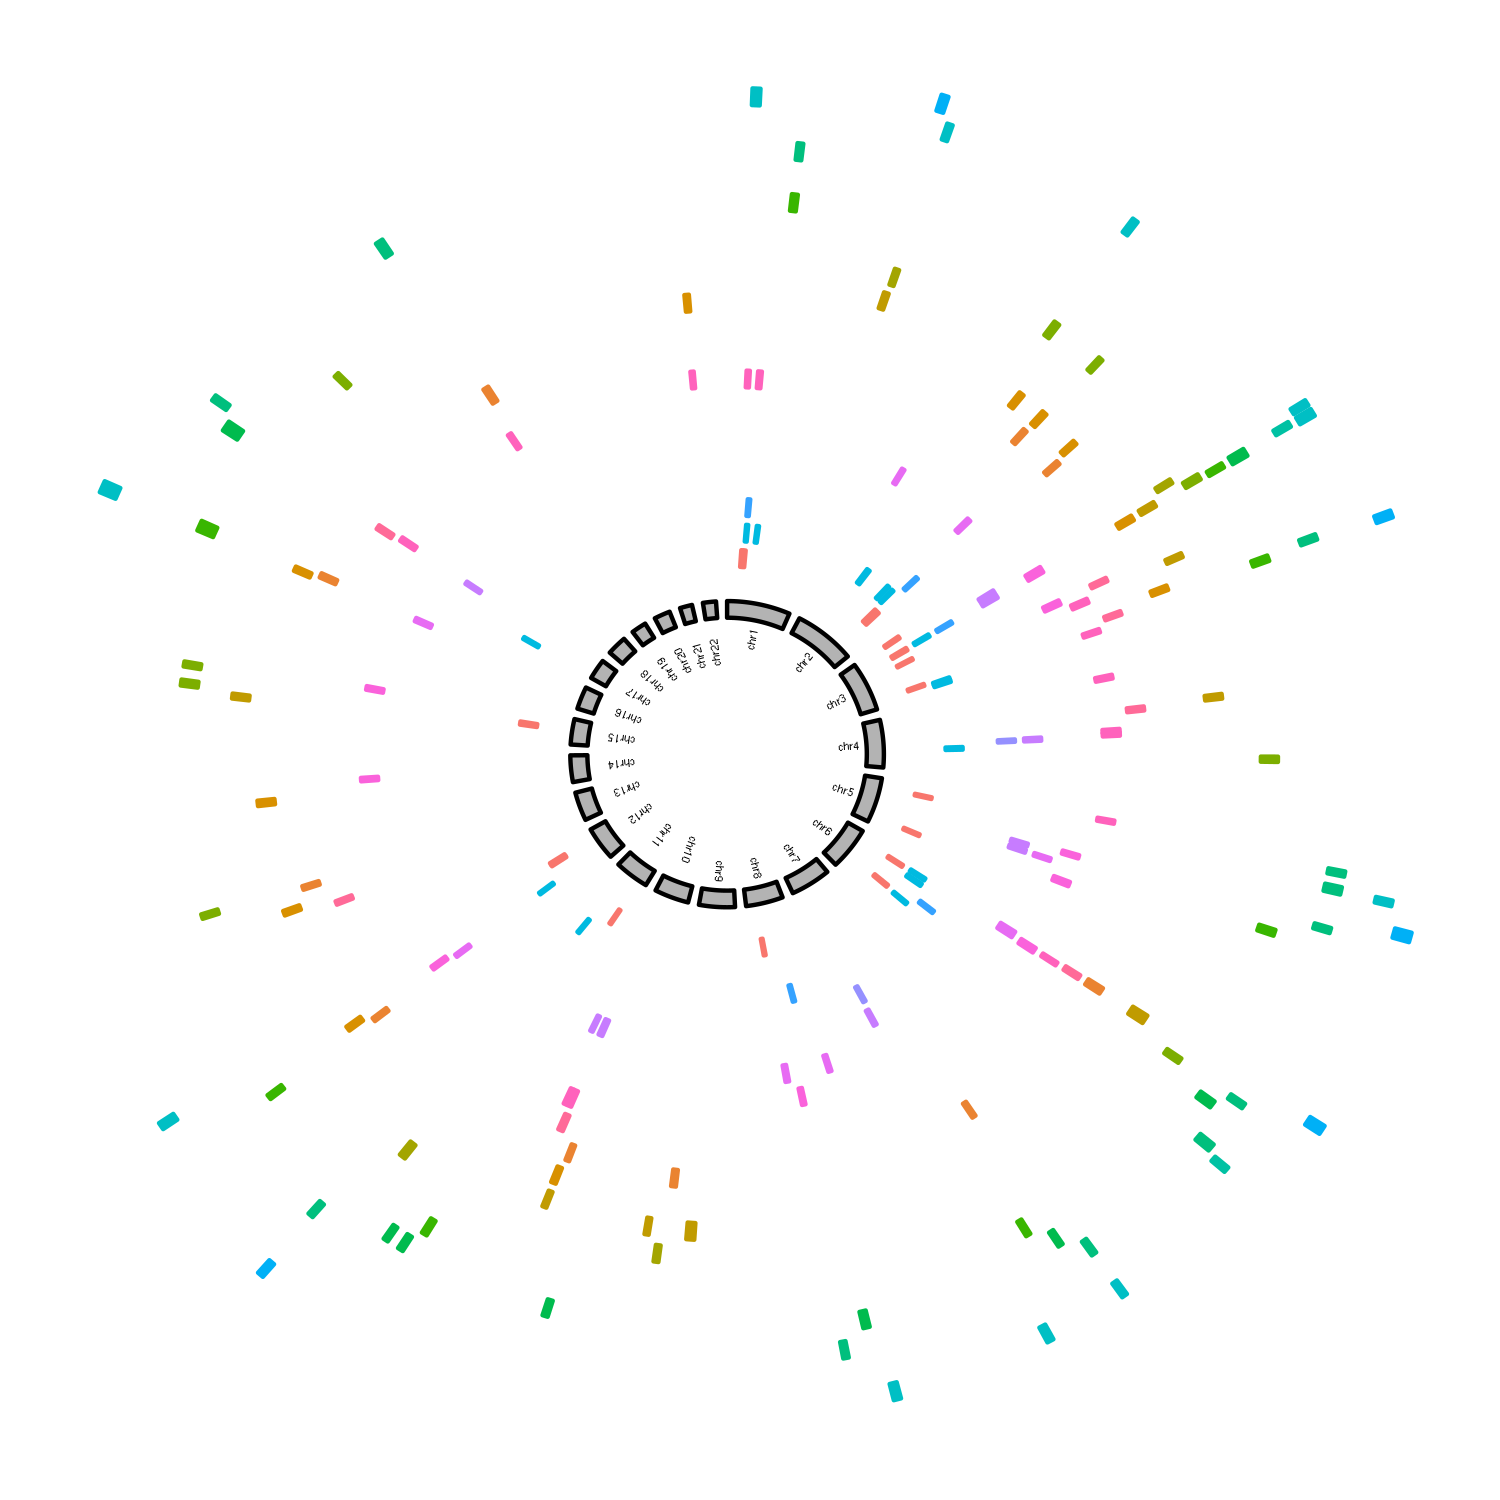

In [527]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 300)

ggbio() + circle(hg19, geom = "rect", fill = "gray70") +
    circle(hg19, geom = "text", aes(label = seqnames, angle = 90), hjust = 3, size = 1) +
    plot_desert(large_deserts_neutral[[1]]) +
    plot_desert(large_deserts_neutral[[2]]) +
    plot_desert(large_deserts_neutral[[3]]) +
    plot_desert(large_deserts_neutral[[4]]) +
    plot_desert(large_deserts_neutral[[5]]) +
    plot_desert(large_deserts_neutral[[6]]) +
    plot_desert(large_deserts_neutral[[7]]) +
    plot_desert(large_deserts_neutral[[8]]) +
    plot_desert(large_deserts_neutral[[9]]) +
    plot_desert(large_deserts_neutral[[10]]) +
    plot_desert(large_deserts_neutral[[11]]) +
    plot_desert(large_deserts_neutral[[12]]) +
    plot_desert(large_deserts_neutral[[13]]) +
    plot_desert(large_deserts_neutral[[14]]) +
    plot_desert(large_deserts_neutral[[15]]) +
    plot_desert(large_deserts_neutral[[16]]) +
    plot_desert(large_deserts_neutral[[17]]) +
    plot_desert(large_deserts_neutral[[18]]) +
    plot_desert(large_deserts_neutral[[19]]) +
    plot_desert(large_deserts_neutral[[20]]) +
    theme(legend.position = "none")

In [9]:
library(tidyverse)
library(bodkanr)


Attaching package: ‘bodkanr’

The following object is masked from ‘package:ggplot2’:

    %+%



In [4]:
x <- read_tsv("../data/slim_coords/exon_unif_recomb_map.bed")

Parsed with column specification:
cols(
  chrom = col_character(),
  start = col_integer(),
  end = col_integer(),
  type = col_character(),
  recomb_rate = col_double(),
  width = col_integer(),
  slim_start = col_integer(),
  slim_end = col_integer()
)


In [13]:
assembly_gaps_path <- "../data/RData/assembly_gaps.rds"

if (!file.exists(assembly_gaps_path)) {
    assembly_gaps <- get_gaps()
    saveRDS(assembly_gaps, assembly_gaps_path)
} else {
    assembly_gaps <- readRDS(assembly_gaps_path)
}

In [25]:
gaps <- assembly_gaps %>% as.data.frame %>% filter(type %in% c("centromere", "heterochromatin"))

In [28]:
gaps

seqnames,start,end,width,strand,bin,ix,n,size,type,bridge
chr7,58054331,61054331,3000001,*,1,564,N,3000000,centromere,no
chr7,61310513,61360513,50001,*,131,569,N,50000,heterochromatin,no
chr7,61917157,61967157,50001,*,1057,575,N,50000,heterochromatin,no


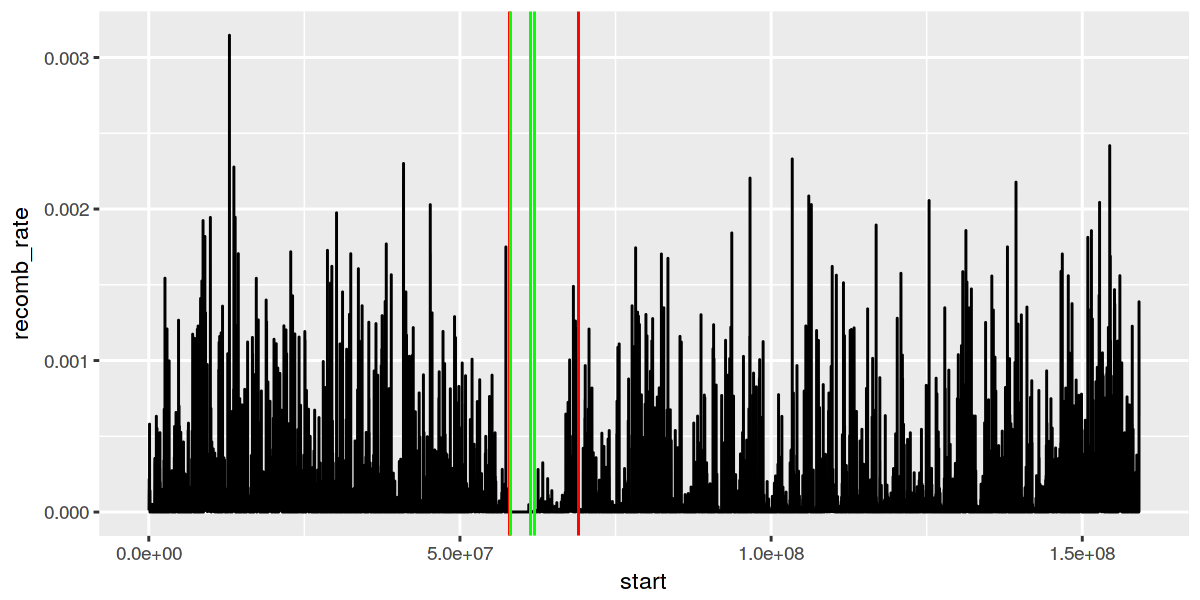

In [31]:
set_dim(8, 4)

filter(x, chrom == "chr7") %>% .[-nrow(.), ] %>%ggplot(aes(start, recomb_rate)) + geom_line() +
geom_vline(xintercept=c(58e6, 69e6), color = "red") +
geom_vline(xintercept=gaps$start, color = "green")

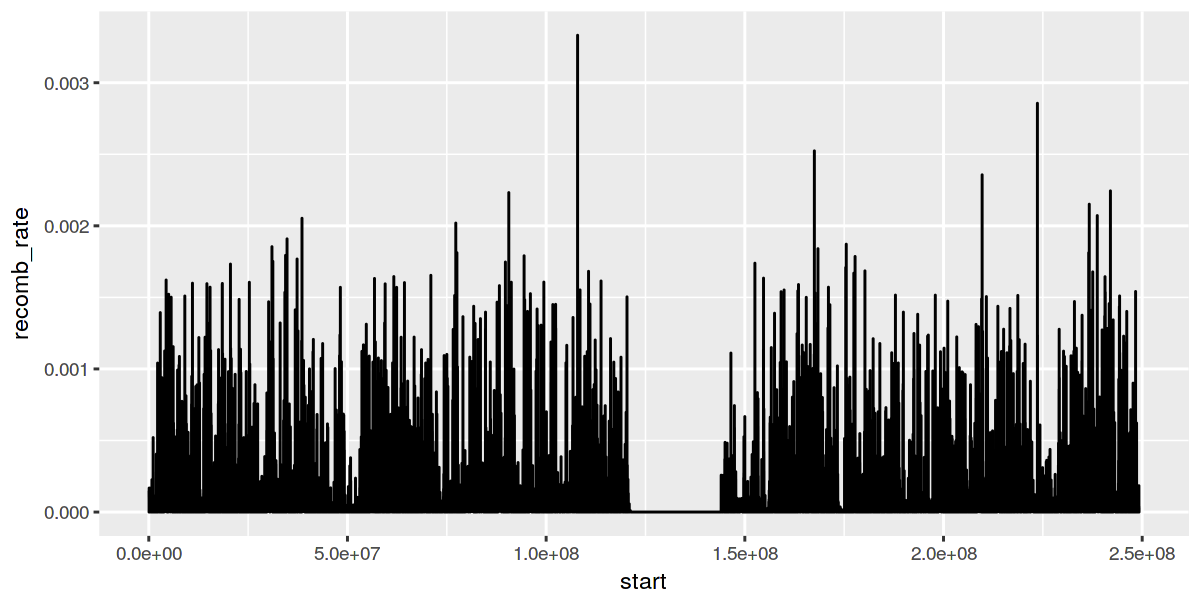

In [32]:
set_dim(8, 4)

filter(x, chrom == "chr1") %>% .[-nrow(.), ] %>%ggplot(aes(start, recomb_rate)) + geom_line()